In [1]:
import os
import warnings
import datetime
import unidecode
import itertools

import numpy as np
import pandas as pd
import seaborn as sns

from github import Github
from matplotlib import pyplot, colors

import sklearn.linear_model

warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
git = Github(os.getenv('GH_TOKEN'))
repo = git.get_repo('sociedatos/bo-mortalidad')

In [3]:
repo_dir = repo.get_contents('.')
repo_dir = {
    os.path.basename(_.path): _ for _ in repo_dir
}

In [4]:
muni_data = pd.read_csv('../update/sdsn.gen.csv')
muni_data = muni_data.set_index('cod_ine')

In [5]:
def stylize_ax(ax, legend=True):
    if type(ax) == np.ndarray:
        [stylize_ax(_, legend) for _ in ax]
        return
    
    ax.grid(
        axis='both',
        which='both',
        color='DarkTurquoise', 
        alpha=0.2, 
        linestyle=':', 
        linewidth=2
    )
    
    if legend:
        ax.legend(loc='upper left')

In [6]:
def year_start(year):
    fourth_jan = datetime.date(year, 1, 4)
    delta = datetime.timedelta(fourth_jan.isoweekday() - 1)
    
    return fourth_jan - delta

def align_precovid_r(df, predict_from=2020):
    base_df = df.loc[:str(predict_from - 1)]
    base_df_index = base_df.index.isocalendar()
    
    base_df = base_df.to_frame().set_index([
        base_df_index.year, base_df_index.week
    ])[df.name]
    base_df = base_df[~base_df.index.duplicated(keep='last')]
    base_df = base_df.unstack(level=0).loc[:52].T.stack()
    
    base_years = base_df.index.get_level_values(0).values.reshape(-1 ,1)
    base_years_n = len(np.unique(base_years))

    onehot = np.concatenate([np.eye(52) for _ in range(base_years_n)])
    predictors = np.concatenate((base_years, onehot), axis=1)

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        predictors, base_df.values
    )

    baseline = reg.predict(
        np.concatenate((np.ones((52, 1)) * predict_from, np.eye(52)), axis=1)
    )
    
    fbase_df = pd.DataFrame([])
    for year in df.loc[str(predict_from):].index.year.unique():
        indexed_base_df = pd.Series(baseline)
        base_df_index = pd.date_range(
            start=year_start(year) + datetime.timedelta(1), 
            end=year_start(year + 1), 
            freq='W'
        )
        if len(base_df_index) == 53:
            indexed_base_df.loc[53] = indexed_base_df.iloc[-1]
            
        indexed_base_df.index = base_df_index
        fbase_df = pd.concat([fbase_df, indexed_base_df])
        
    return fbase_df[0].rename(df.name)[:df.index[-1]]

def align_precovid(df, predict_from=2020):
    # https://github.com/dkobak/excess-mortality/blob/main/all-countries.ipynb
    base_df = df.copy()
    base_df_index = base_df.index.isocalendar()

    base_df = base_df.to_frame().set_index([
        base_df_index.year, base_df_index.week
    ])[df.name]
    base_df = base_df[~base_df.index.duplicated(keep='last')]
    base_df = base_df.dropna().unstack(level=0).loc[:52].T.stack(dropna=False)
    base_df = base_df.loc[2010:]

    base_years = base_df.loc[:(predict_from - 1)].index.get_level_values(0).values.reshape(-1 ,1)
    base_years_n = len(np.unique(base_years))

    onehot = np.concatenate([np.eye(52) for _ in range(base_years_n)])
    predictors = np.concatenate((base_years, onehot), axis=1)

    reg = sklearn.linear_model.LinearRegression(fit_intercept=False).fit(
        predictors, base_df.loc[:(predict_from - 1)].values
    )
    
    predict_years = base_df.loc[predict_from:].index.get_level_values(0).values.reshape(-1 ,1)
    predict_years_n = len(np.unique(predict_years))

    onehot = np.concatenate([np.eye(52) for _ in range(predict_years_n)])
    predictors = np.concatenate((predict_years, onehot), axis=1)

    baseline = reg.predict(predictors)
    baseline_df = pd.Series(baseline, index=base_df.loc[predict_from:].index)
    
    fbase_df = None
    for year, year_data in baseline_df.groupby(level=0):
        year_data = year_data.copy()
        base_df_index = pd.date_range(
            start=year_start(year) + datetime.timedelta(1), 
            end=year_start(year + 1), 
            freq='W'
        )
        if len(base_df_index) == 53:
            year_data[(year, 53)] = year_data.iloc[-1]

        year_data.index = base_df_index
        fbase_df = pd.concat([fbase_df, year_data])
        
    fbase_df[fbase_df < 0] = 0
    
    return fbase_df.rename(df.name)[:df.index[-1]]


### reportes diarios

In [7]:
reported_deaths_df = pd.read_csv(
    'https://github.com/sociedatos/covid19-bo-casos_por_departamento/raw/master/decesos_acumulados.csv',
    index_col=0
)

reported_deaths_df.index = pd.to_datetime(reported_deaths_df.index)
reported_deaths_df = reported_deaths_df.sort_index()

reported_deaths_df.columns = [
    unidecode.unidecode(_).lower().replace(' ', '.') for _ in reported_deaths_df.columns
]


In [8]:
for _ in range(3):
    reported_deaths_df[(reported_deaths_df.diff() < 0).shift(-1).fillna(False)] = np.nan
    reported_deaths_df = reported_deaths_df.interpolate('from_derivatives', limit_area='inside')

for _ in range(3):
    reported_deaths_df[reported_deaths_df.diff() < 0] = np.nan
    reported_deaths_df = reported_deaths_df.interpolate('from_derivatives', limit_area='inside')

In [9]:
reported_deaths_df = reported_deaths_df.round()

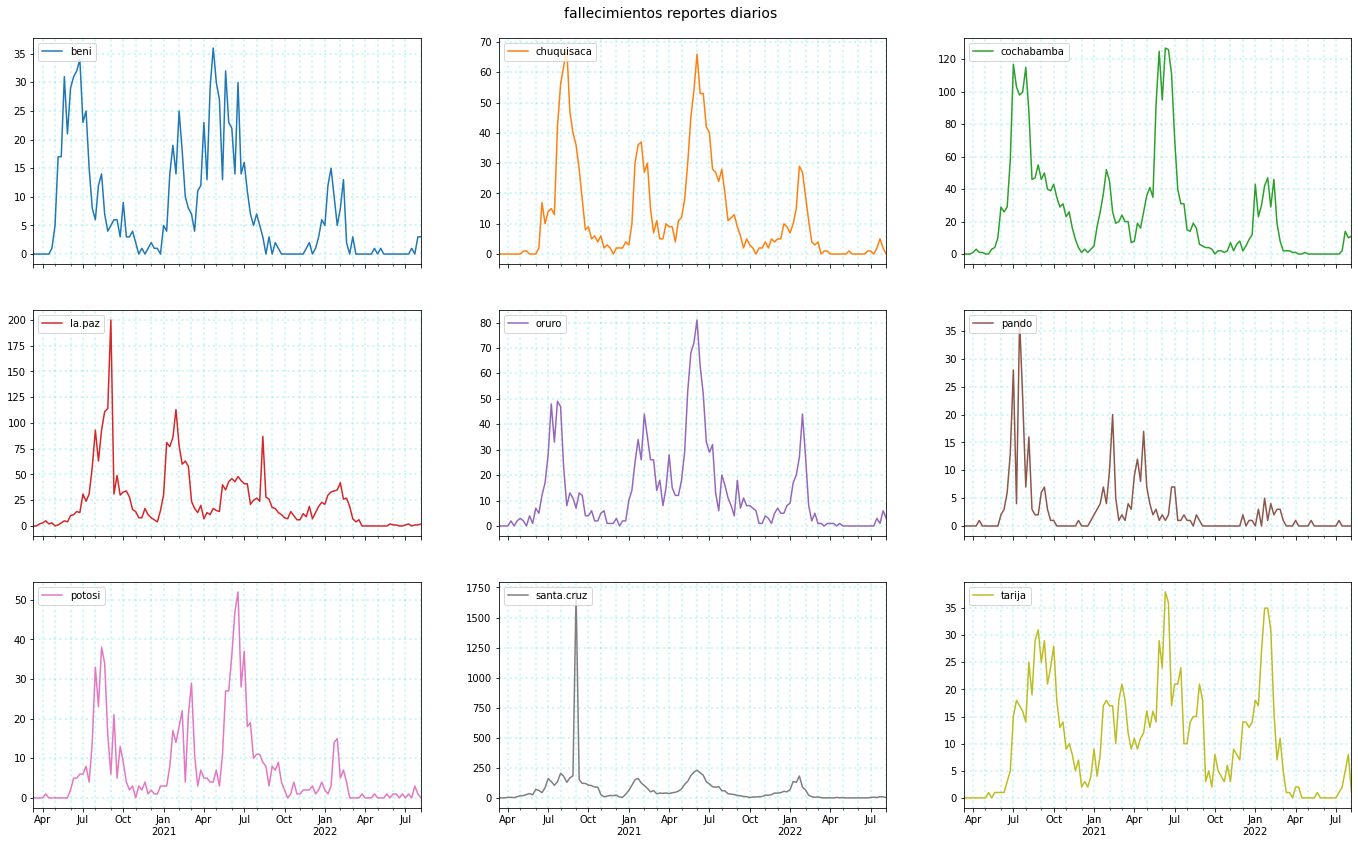

In [10]:
axs = reported_deaths_df[sorted(reported_deaths_df.columns)].diff().resample('W').sum().plot(
    subplots=True, 
    layout=(3, 3),
    figsize=(60/2.54, 36/2.54)
)

axs[0][1].get_figure().suptitle('fallecimientos reportes diarios', y=.91, fontsize=14)
stylize_ax(axs)

### siahv covid

In [11]:
siahv_dept_data = pd.read_csv(repo_dir['hechos.vitales.covid.csv'].download_url)

In [12]:
siahv_dept_data[['fecha_registro', 'fecha_deceso']] = siahv_dept_data[
    ['fecha_registro', 'fecha_deceso']
].apply(pd.to_datetime)

In [13]:
siahv_dept_data = siahv_dept_data.set_index(siahv_dept_data.columns[:-1].to_list())['decesos']
siahv_dept_data = siahv_dept_data.unstack(level='fecha_registro').T

In [14]:
siahv_dept_data_ = siahv_dept_data.groupby(level=['departamento', 'fecha_deceso'], axis=1).sum()
siahv_dept_data_ = siahv_dept_data_.resample('W').sum().T

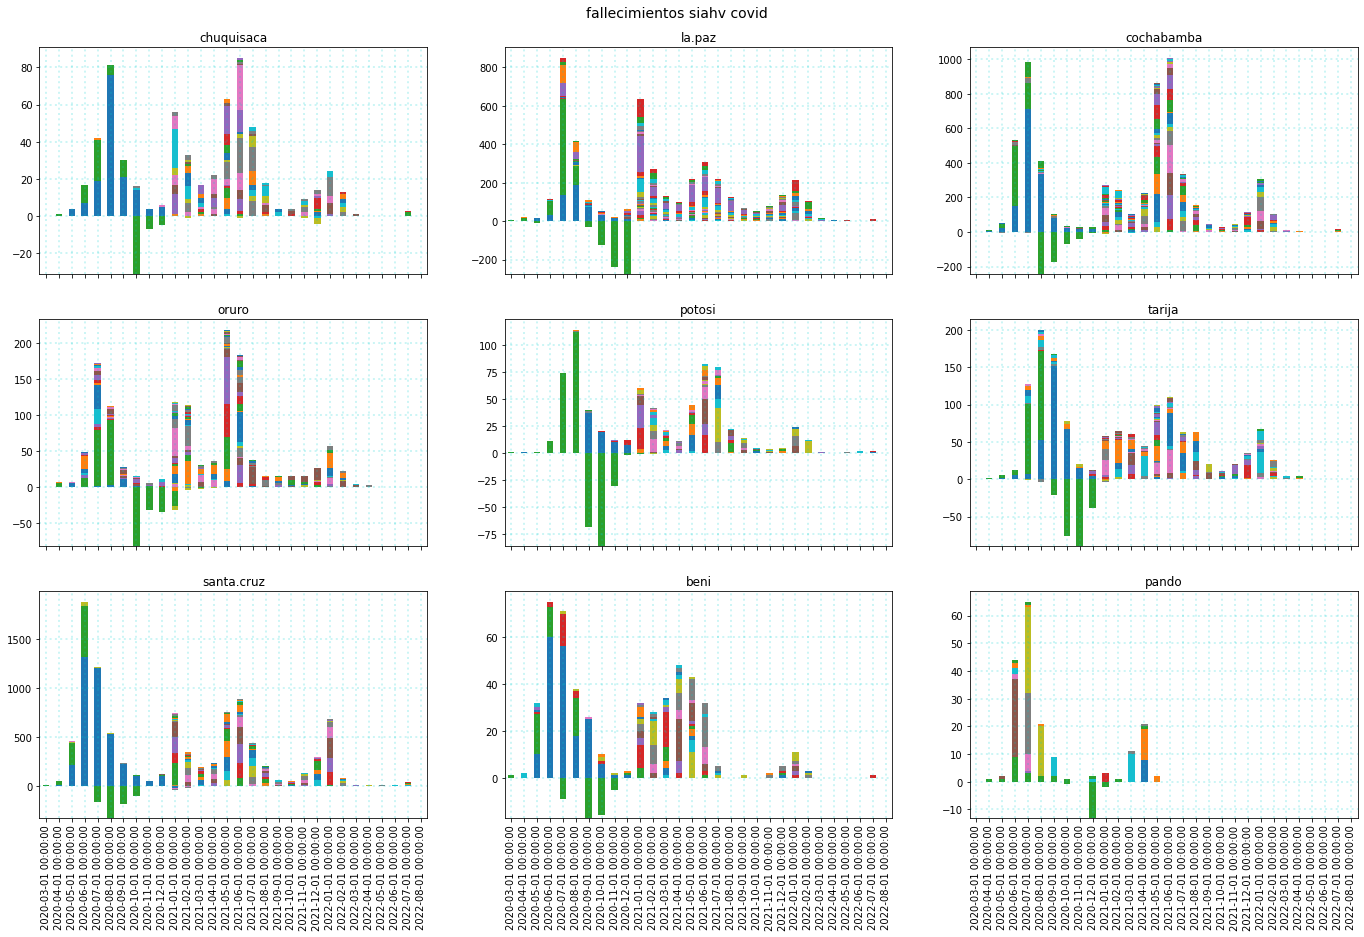

In [15]:
fig, axs = pyplot.subplots(
    ncols=3, 
    nrows=3, 
    sharex=True,
    figsize=(60/2.54, 36/2.54)
)
axs = axs.flatten()

siahv_dept_data_ = siahv_dept_data.groupby(level=[0, 4], axis=1).sum().resample('W').sum().T
siahv_dept_data_ = siahv_dept_data_.loc[reported_deaths_df.columns]
siahv_max_date = siahv_dept_data_.index.get_level_values(1).max()

for idx, dept_data in enumerate(siahv_dept_data_.groupby(level=0, sort=False)):
    dept_name, dept_data = dept_data
    dept_data = dept_data.loc[dept_name]
    
    sdd_dates = dept_data.replace(0, np.nan).T.apply(
        lambda _: _.first_valid_index()
    )
    sdd_height_fix = dept_data[dept_data < 0].sum(axis=1)
    sdd_height_fix = sdd_height_fix.replace(0, np.nan).dropna()

    sdd_height_fix = pd.concat([sdd_dates, sdd_height_fix], axis=1).dropna()

    for death_date, register_date, fix_by in sdd_height_fix.itertuples():
        dept_data.at[death_date, register_date] = (
            dept_data.at[death_date, register_date] + fix_by
        )
    
    dept_data.reindex(
        pd.date_range('2020-03-01', siahv_max_date, freq='MS')
    ).plot(
        kind='bar', stacked=True, ax=axs[idx], legend=None
    )
    axs[idx].set_title(dept_name)
    
fig.suptitle('fallecimientos siahv covid', y=.92, fontsize=14)
stylize_ax(axs, legend=False)

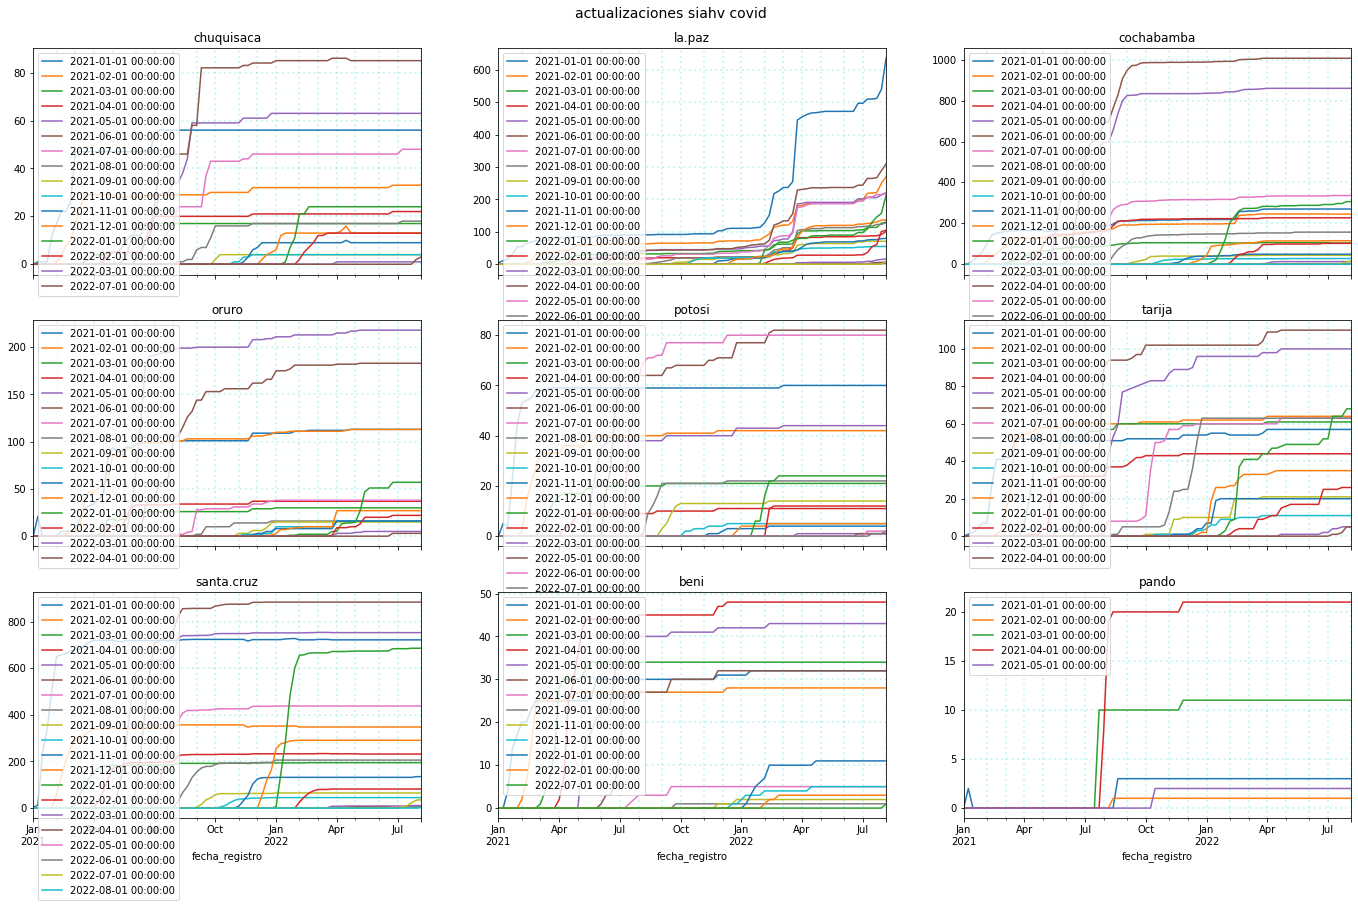

In [16]:
fig, axs = pyplot.subplots(
    ncols=3, 
    nrows=3, 
    sharex=True,
    figsize=(60/2.54, 36/2.54)
)
axs = axs.flatten()

for idx, dept_data in enumerate(siahv_dept_data_.groupby(level=0, sort=False)):
    dept_name, dept_data = dept_data
    dept_data = dept_data.loc[dept_name]
    
    dept_data.loc['2021-01-01':].T.cumsum().plot(ax=axs[idx])
    axs[idx].set_title(dept_name)
    
fig.suptitle('actualizaciones siahv covid', y=.92, fontsize=14)
stylize_ax(axs)

In [17]:
siahv_dept_data_.groupby(level=0).sum().sum(axis=1)

departamento
beni           505.0
chuquisaca     614.0
cochabamba    6071.0
la.paz        4396.0
oruro         1316.0
pando          183.0
potosi         718.0
santa.cruz    9794.0
tarija        1382.0
dtype: float64

In [18]:
siahv_dept_data_age = siahv_dept_data.groupby(
    level=['departamento', 'edad', 'fecha_deceso'], 
    axis=1
).sum().sum()

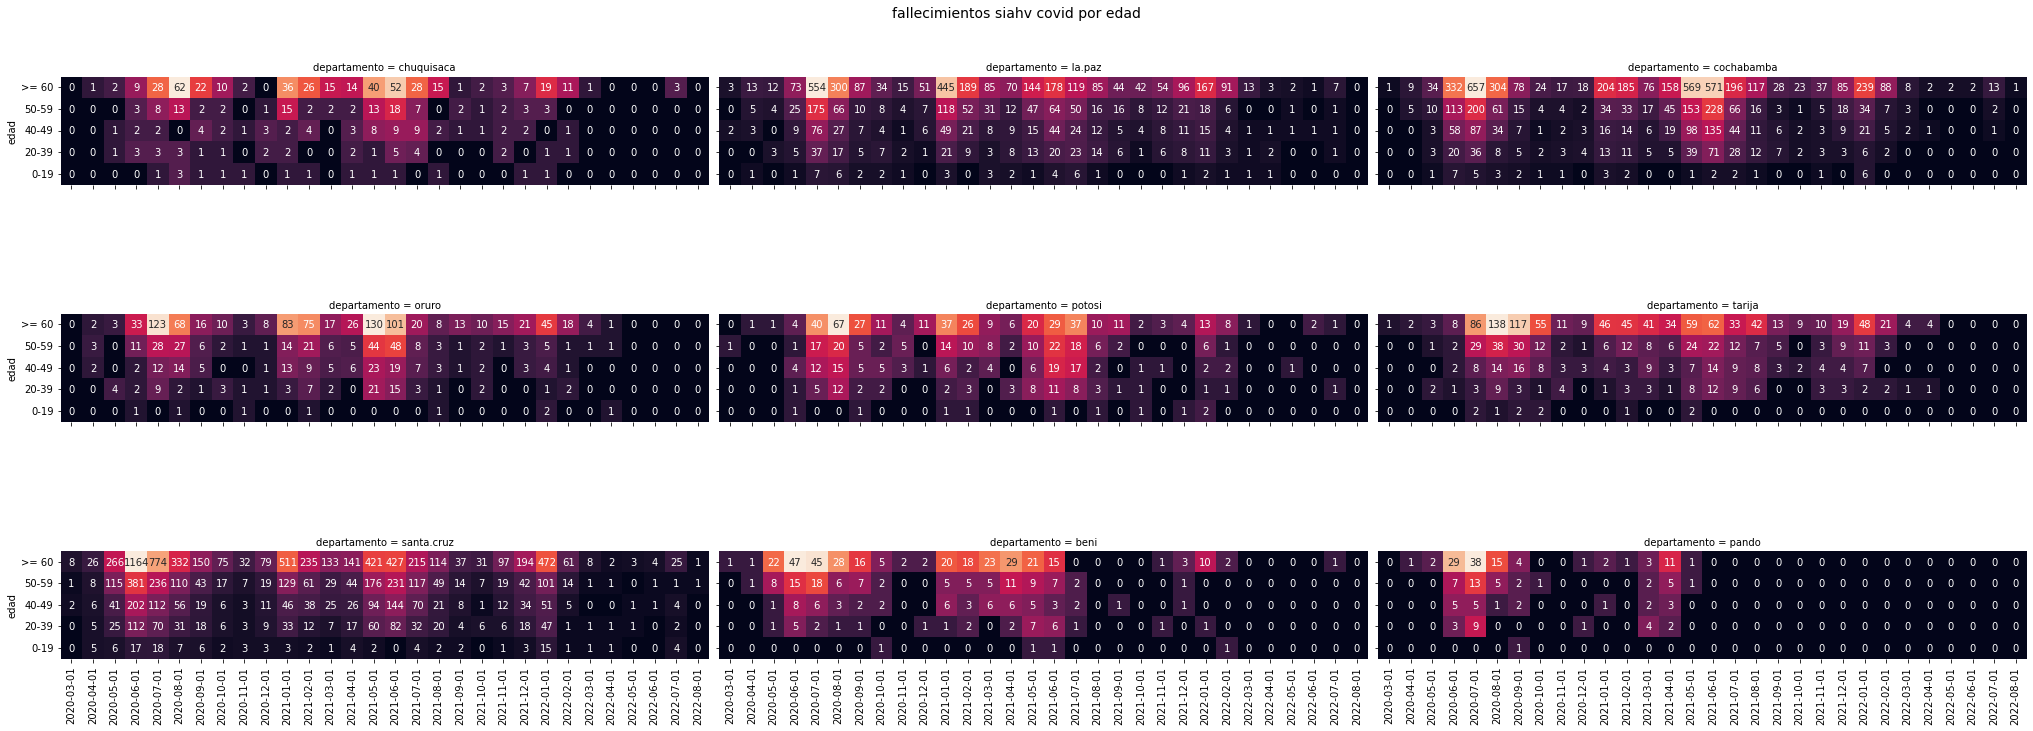

In [19]:
def plot_heatmap(**kwargs):
    data = kwargs.pop('data')
    data_max = data['decesos'].max()
    
    data = data.pivot(index='edad', columns='fecha_deceso', values='decesos')
    data = data.loc[data.index[::-1]]
    data.columns = [_.strftime('%Y-%m-%d') for _ in data.columns]
    
    sns.heatmap(
        data,
        norm=colors.PowerNorm(1/2, vmin=0, vmax=data_max),
        **kwargs
    )

siahv_dept_data_age_ = siahv_dept_data_age.unstack(level='fecha_deceso')
siahv_dept_data_age_ = siahv_dept_data_age_.fillna(0).stack().rename('decesos')
siahv_dept_data_age_ = siahv_dept_data_age_.loc[reported_deaths_df.columns]

g = sns.FacetGrid(
    siahv_dept_data_age_.reset_index(), 
    col='departamento', 
    col_wrap=3, 
    height=10/2.54,
    aspect=60/25
)
g.map_dataframe(
    plot_heatmap, 
    annot=True,
    fmt=".0f",
    square=True,
    cbar=False,
)

_ = g.fig.suptitle('fallecimientos siahv covid por edad', y=.925, fontsize=14)

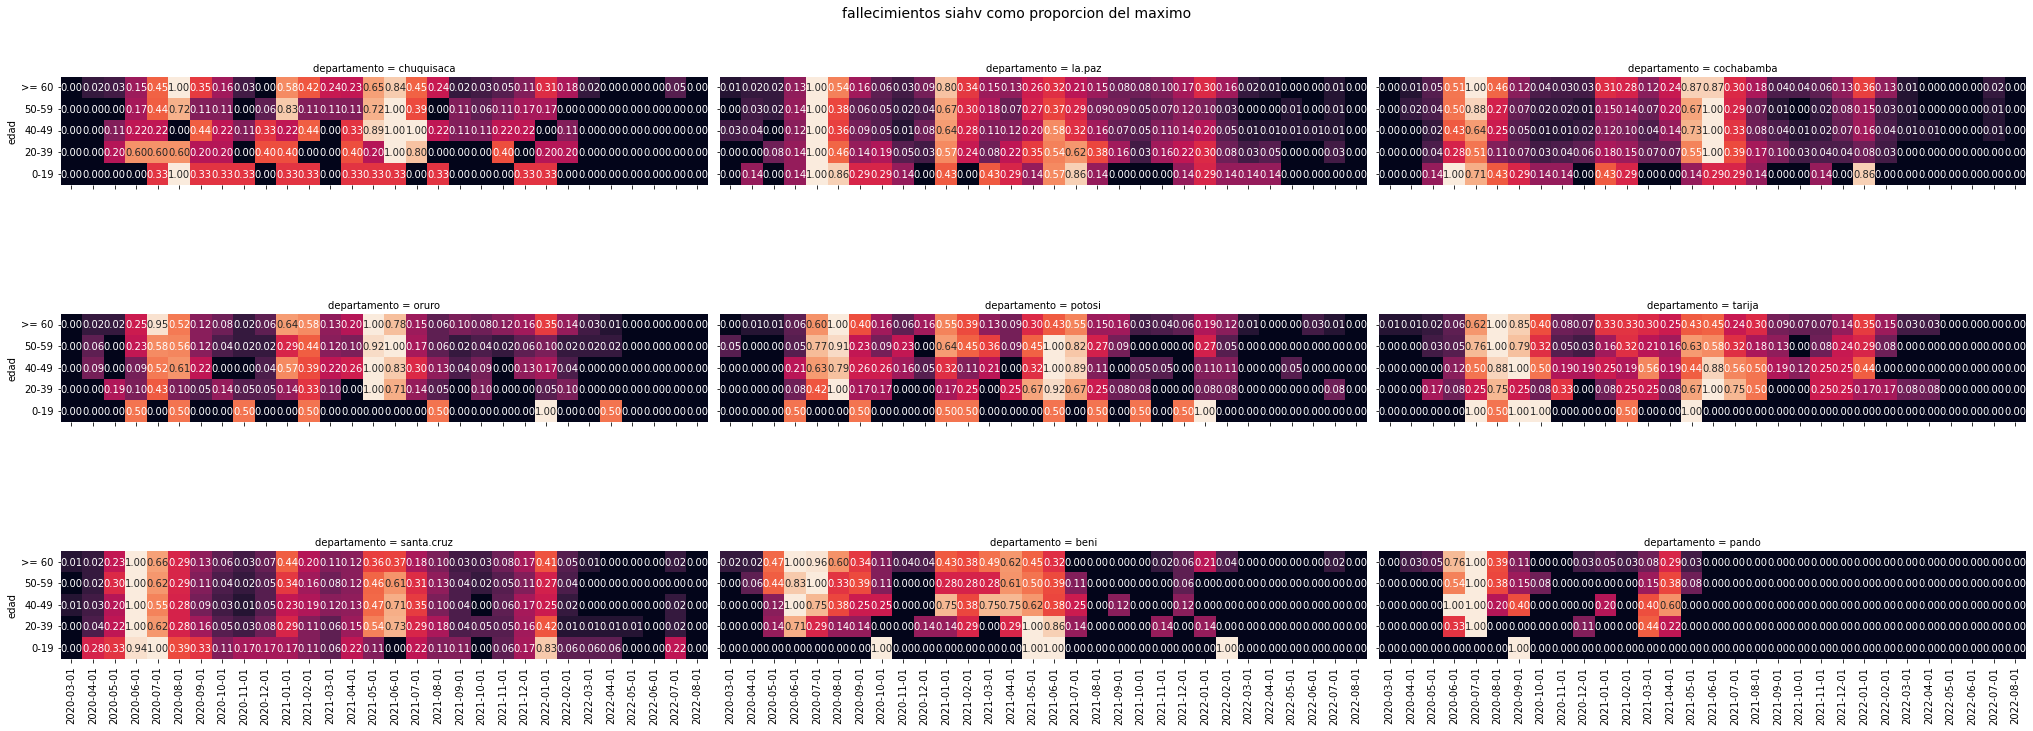

In [20]:
siahv_dept_data_age_scaled = siahv_dept_data_age_.groupby(level=['departamento', 'edad']).apply(
    lambda _: (_ / _.max()).round(2)
)

g = sns.FacetGrid(
    siahv_dept_data_age_scaled.reset_index(), 
    col='departamento', 
    col_wrap=3, 
    height=10/2.54,
    aspect=60/25
)
g.map_dataframe(
    plot_heatmap, 
    annot=True,
    fmt=".2f",
    square=True,
    cbar=False,
)

_ = g.fig.suptitle('fallecimientos siahv como proporcion del maximo', y=.925, fontsize=14)

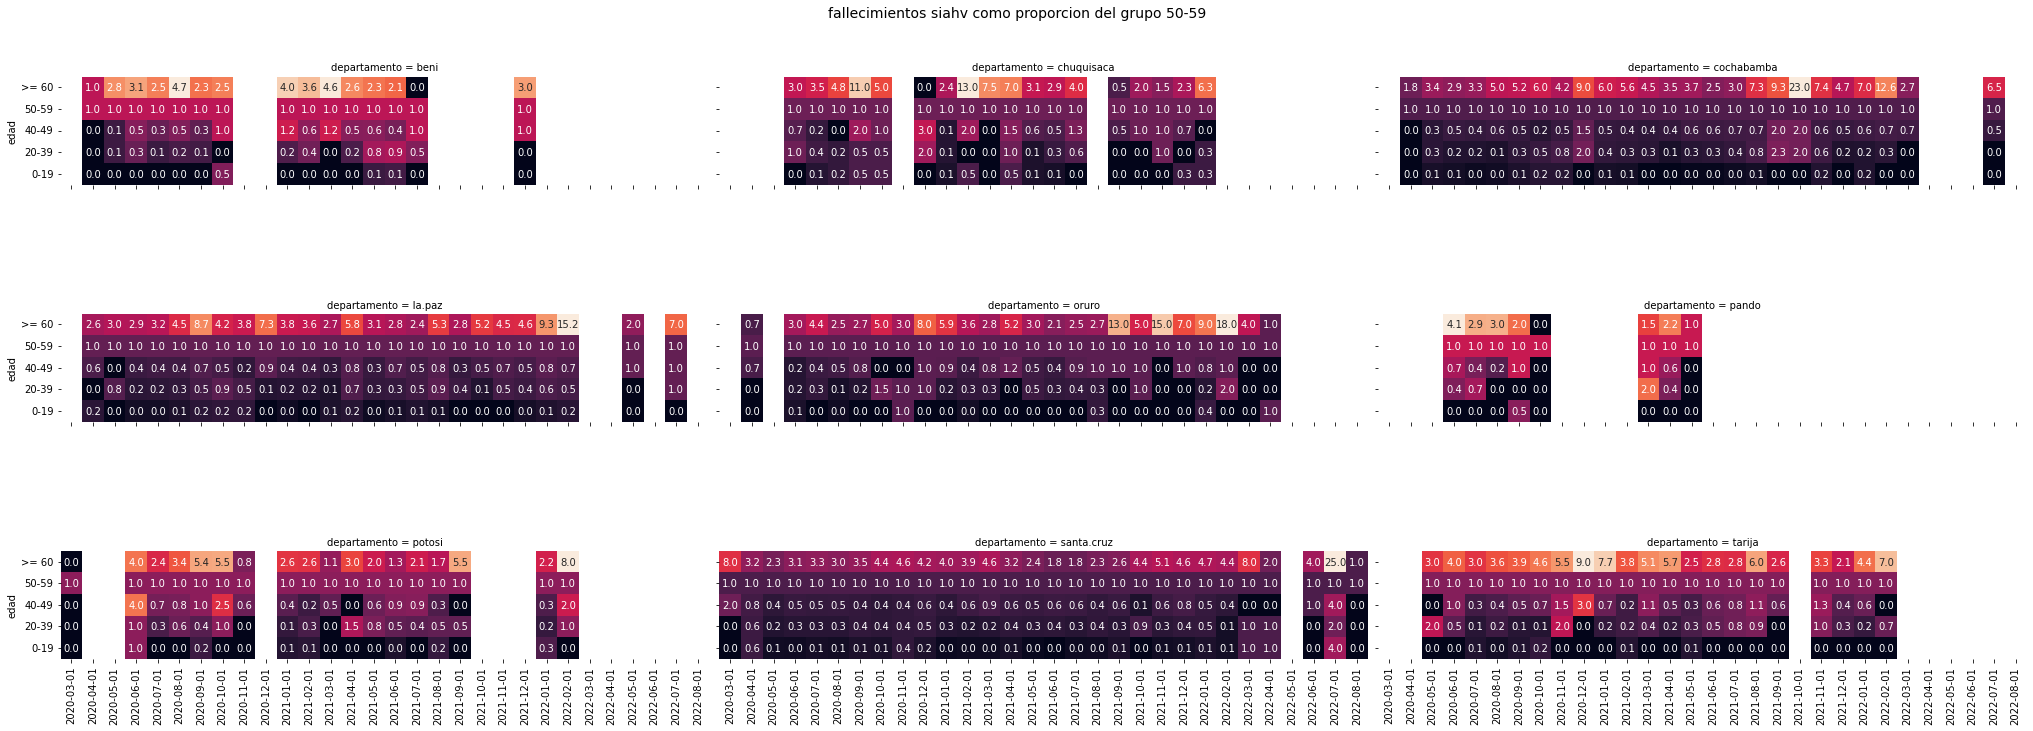

In [21]:
siahv_dept_data_age_scaled = siahv_dept_data_age_.groupby(level=['departamento']).apply(
    lambda _: (
        (_.unstack('edad').T / _.unstack('edad')['50-59']).unstack()
    )
)
siahv_dept_data_age_scaled = siahv_dept_data_age_scaled.replace(np.inf, np.nan)
siahv_dept_data_age_scaled = siahv_dept_data_age_scaled.droplevel(0)

g = sns.FacetGrid(
    siahv_dept_data_age_scaled.reset_index(), 
    col='departamento', 
    col_wrap=3, 
    height=10/2.54,
    aspect=60/25
)
g.map_dataframe(
    plot_heatmap, 
    annot=True,
    fmt=".1f",
    square=True,
    cbar=False,
)

_ = g.fig.suptitle('fallecimientos siahv como proporcion del grupo 50-59', y=.925, fontsize=14)

### snis

In [22]:
snis_muni_df = pd.read_csv(repo_dir['sistema.informacion.salud.csv'].download_url)

In [23]:
snis_muni_df['fecha'] = pd.to_datetime(snis_muni_df['fecha'])
snis_muni_df = snis_muni_df.set_index(snis_muni_df.columns[:-1].to_list())['decesos']

In [24]:
muni_data_depts = muni_data.groupby(lambda _: str(_)[0])['departamento'].first()

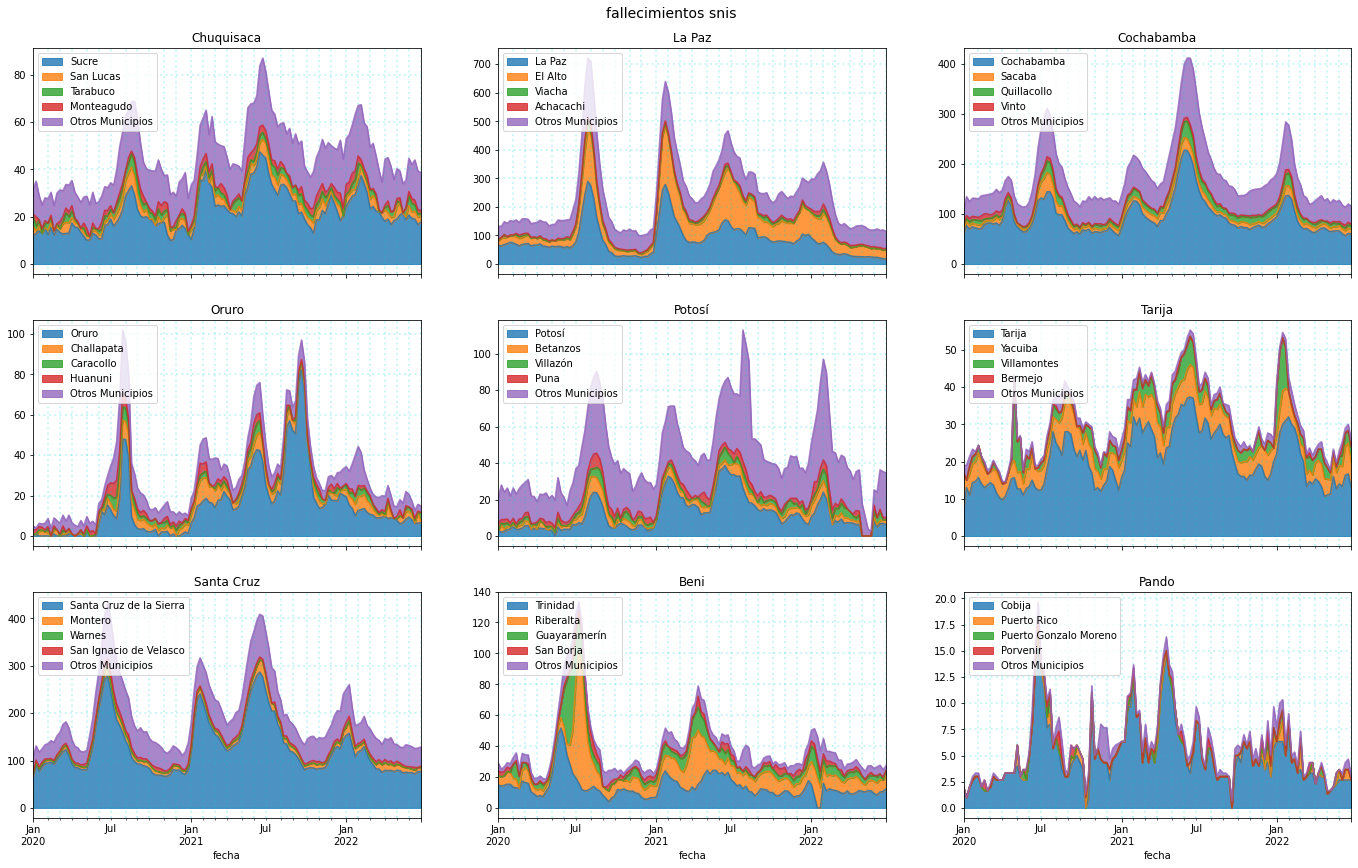

In [25]:
fig, axs = pyplot.subplots(
    ncols=3, 
    nrows=3, 
    sharex=True,
    figsize=(60/2.54, 36/2.54)
)
axs = axs.flatten()

for dept_id, dept_df in snis_muni_df.groupby(lambda _: str(_[0])[0]):
    dept_df = dept_df.groupby(level=['cod_ine', 'fecha']).sum()
    dept_df = dept_df.unstack(level='cod_ine')
    
    dept_idx = dept_df.sum().sort_values(ascending=False)
    
    dept_plot_df = dept_df[dept_idx[:4].index].copy()
    dept_plot_df = dept_plot_df.rename(columns=muni_data['municipio'])
    dept_plot_df['Otros Municipios'] = dept_df[dept_idx[4:].index].sum(axis=1)
    
    dept_plot_df = dept_plot_df.loc['2020':]
    
    dept_plot_df.rolling(window=3).mean().fillna(dept_plot_df).plot(
        title=muni_data_depts[dept_id], kind='area', alpha=.8, ax=axs[int(dept_id) - 1]
    )
    
_ = fig.suptitle('fallecimientos snis', y=.92, fontsize=14)
stylize_ax(axs)

In [26]:
snis_muni_age_df = snis_muni_df.unstack(level='fecha').groupby([
    'cod_ine', 'rango_edad'
]).sum()

snis_muni_age_df.columns = snis_muni_age_df.columns + pd.Timedelta(days=3)
snis_muni_age_df = snis_muni_age_df.unstack(level='rango_edad')

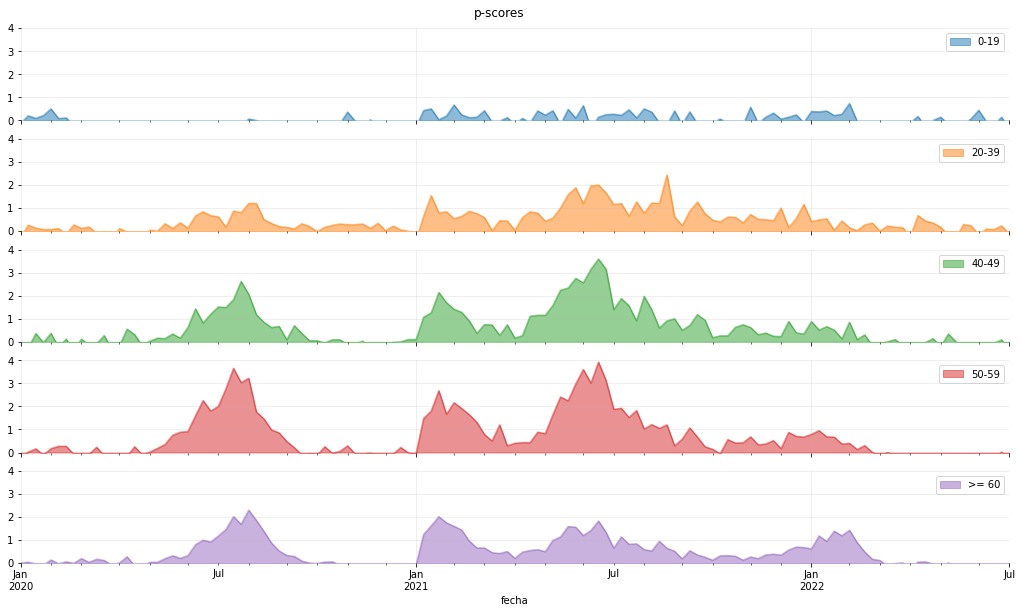

In [27]:
ttt_df = snis_muni_age_df.groupby(lambda _: str(_)[0]).sum().stack(level='rango_edad').loc['2'].T
ttt_df = snis_muni_age_df.sum().unstack(level='rango_edad')
bttt_df = ttt_df.apply(align_precovid).round()

axs = ((ttt_df.loc['2020':].resample('W').sum() - bttt_df) / bttt_df).round(2).plot(
    subplots=True, figsize=(45/2.54, 25/2.54), kind='area', stacked=False
)
axs[0].get_figure().suptitle('p-scores', y=.91)
_ = [ax.set(frame_on=False) for ax in axs]
_ = [ax.grid(alpha=.25) for ax in axs]
_ = [ax.set_ylim(0, 4) for ax in axs]

In [28]:
def get_pscore(snis_dept_age_df, align_fn=align_precovid):
    base_snis_dept_age_df = snis_dept_age_df.apply(align_fn).round()
    
    base_snis_dept_age_df.loc[:, 'Cochabamba'] = align_fn(snis_dept_age_df.loc['2019':, 'Cochabamba'])
    base_snis_dept_age_df.loc[:, 'Potosí'] = align_precovid_r(snis_dept_age_df['Potosí'], predict_from=2019)
    base_snis_dept_age_df.loc[:, 'Pando'] = snis_dept_age_df.loc['2020':'2020-03-31', 'Pando'].mean()

    snis_dept_age_df = snis_dept_age_df.loc['2020':].resample('W').sum()
    snis_dept_age_df = snis_dept_age_df.rolling(window=4).mean().fillna(snis_dept_age_df)
    snis_dept_age_df = (snis_dept_age_df - base_snis_dept_age_df) / base_snis_dept_age_df
    
    return snis_dept_age_df

snis_dept_age_df = snis_muni_age_df.groupby(lambda _: str(_)[0]).sum().T
snis_dept_age_df = snis_dept_age_df.rename(
    columns=muni_data.groupby(lambda _: str(_)[0])['departamento'].first()
)

In [29]:
snis_dept_age_df_ = snis_dept_age_df.groupby(level='fecha').sum()
snis_dept_age_df__ = snis_dept_age_df.xs('>= 60', level='rango_edad')
snis_dept_age_df_ = snis_dept_age_df_ - snis_dept_age_df__

snis_dept_age_df_ = pd.concat(
    [snis_dept_age_df_, snis_dept_age_df__], 
    axis=1, 
    keys=['< 60', '>= 60']
)
snis_dept_age_df_ = snis_dept_age_df_.rolling(window=2).mean().fillna(snis_dept_age_df_)

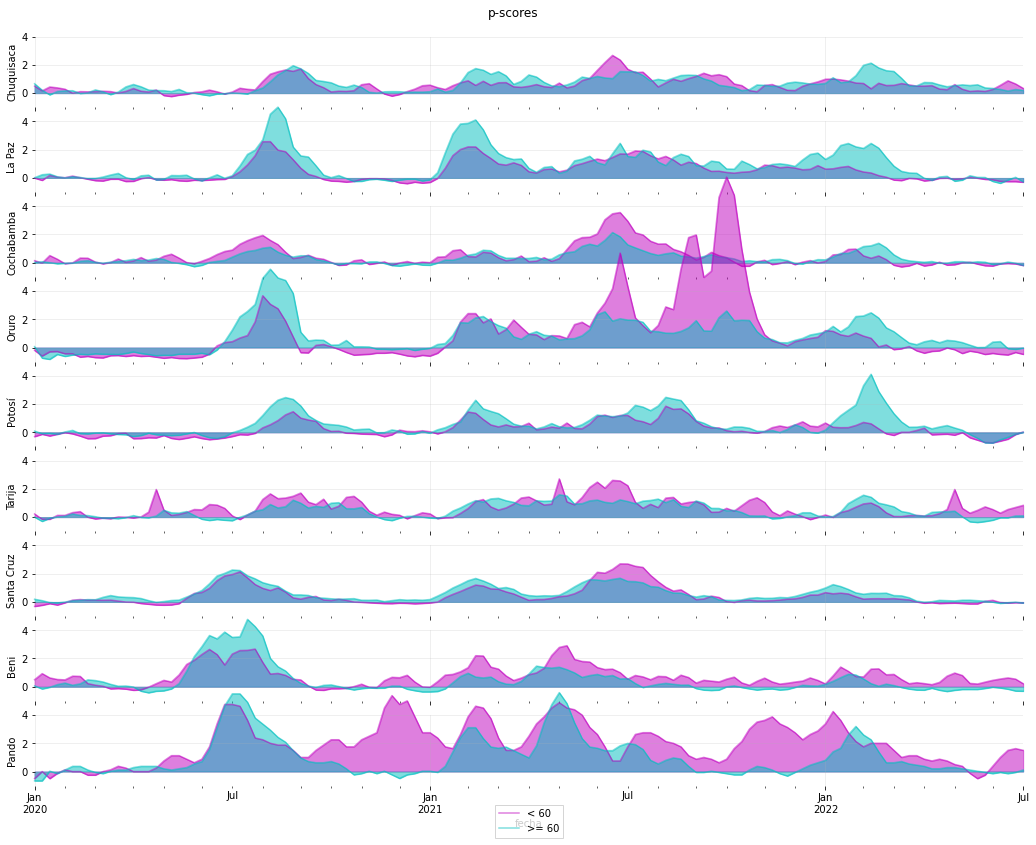

In [30]:
axs = get_pscore(snis_dept_age_df_['< 60'], align_precovid_r).plot(
    subplots=True, 
    figsize=(45/2.54, 35/2.54), 
    kind='area', 
    stacked=False,
    clip_on=False,
    color='m',
    legend=None
)

axs = get_pscore(snis_dept_age_df_['>= 60']).plot(
    subplots=True, 
    kind='area', 
    stacked=False,
    clip_on=False,
    ax=axs,
    color='c',
    legend=None
)

axs[0].get_figure().suptitle('p-scores', y=.91)

for idx, ax in enumerate(axs):
    ax.set(frame_on=False)
    ax.grid(alpha=.25)
    ax.set_ylim(-1, 4)
    ax.set_ylabel(snis_dept_age_df_['< 60'].columns[idx])
    
_ = axs[-1].legend(
    axs[0].get_lines(),  
    ['< 60', '>= 60'], 
    bbox_to_anchor=(0.5, -0.2),
    fancybox=False, 
    shadow=False,
    loc = 'upper center'
)

### sereci

In [31]:
sereci_df = pd.read_csv(
    repo_dir['registro.civil.csv'].download_url, 
    index_col=0
)
sereci_df.index = pd.to_datetime(sereci_df.index)

sereci_df.columns = [_.lower().replace(' ', '.') for _ in sereci_df.columns]
sereci_df = sereci_df[sorted(sereci_df.columns)]

sereci_df.tail(5)

,beni,chuquisaca,cochabamba,la.paz,oruro,pando,potosi,santa.cruz,tarija
fecha,,,,,,,,,
2021-05-01,257,397,2006,2041,648,33,466,2144,345
2021-06-01,230,510,2377,2634,672,23,705,2443,348
2021-07-01,223,550,1433,2330,375,26,663,1953,367
2021-08-01,183,419,1117,1913,348,18,545,1497,338
2021-09-01,182,310,976,1640,323,22,428,1242,272


In [32]:
def resample_monthly(df, method='from_derivatives', **kwargs):
    df = df.copy()
    
    df_index = df.iloc[-1:].resample('W').mean().index
    df_index_diff = (
        (df_index + pd.offsets.MonthBegin(1)) - df_index
    )
    df_index_diff = np.floor(
        df_index_diff / pd.Timedelta(days=7)
    )[0] * 7 + df_index.day[0] - 1

    df_index = df.index[0]
    df.index = df.index + pd.DateOffset(
        days=df_index_diff
    )

    df.loc[
        pd.to_datetime(df_index) - pd.DateOffset(days=1)
    ] = 0
    df = df.sort_index()

    df = df.cumsum().asfreq('d')
    df = df.interpolate(method, **kwargs)
    
    df = df.diff().dropna().resample('W').sum()
    df = df.round()
    
    return df

In [33]:
resample_sereci_df = resample_monthly(sereci_df)

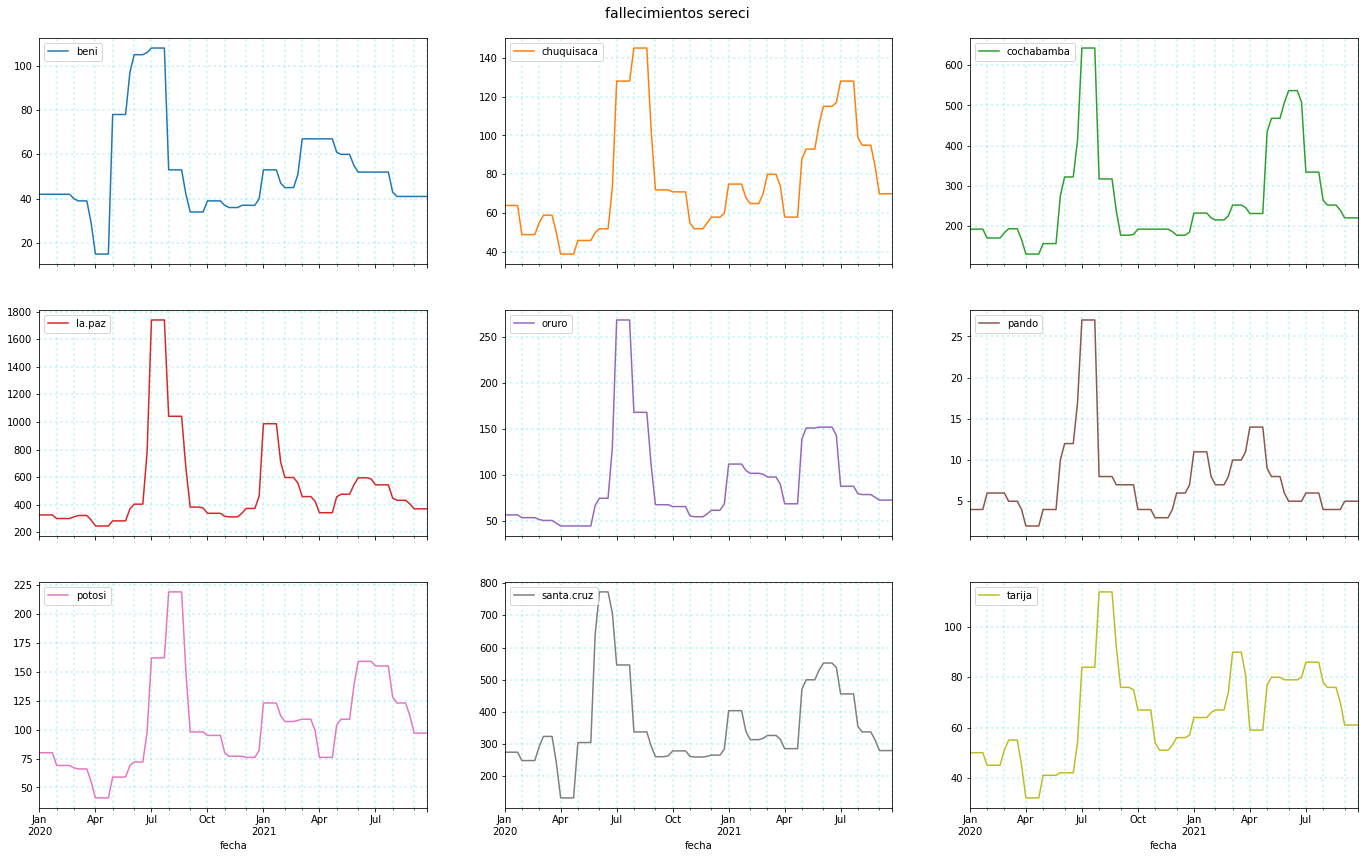

In [34]:
axs = resample_sereci_df['2020':].plot(
    subplots=True, 
    layout=(3, 3),
    figsize=(60/2.54, 36/2.54)
)

axs[0][0].get_figure().suptitle('fallecimientos sereci', y=.91, fontsize=14)
stylize_ax(axs)

### Comparativo

In [35]:
snis_mortality_df = snis_muni_df.groupby(level=['cod_ine', 'fecha']).sum()

In [36]:
snis_mortality_df = snis_mortality_df.unstack(level='fecha').groupby(
    lambda _: str(_)[0]
).sum().T

In [37]:
muni_data_name = muni_data.groupby(
    lambda _: str(_)[0]
)['departamento'].unique()
muni_data_name = muni_data_name.apply(
    lambda _: unidecode.unidecode(_[0]).lower().replace(' ', '.')
)

snis_mortality_df = snis_mortality_df.rename(muni_data_name, axis=1)

In [38]:
snis_mortality_df.index = snis_mortality_df.index + pd.Timedelta(days=3)

In [39]:
snis_bases_df = snis_mortality_df.apply(align_precovid)
snis_bases_df.loc[:, 'cochabamba'] = align_precovid(snis_mortality_df.loc['2019':, 'cochabamba'])
snis_bases_df.loc[:, 'potosi'] = align_precovid_r(snis_mortality_df['potosi'], predict_from=2019)
snis_bases_df.loc[:, 'pando'] = snis_mortality_df.loc['2020':'2020-03-31', 'pando'].mean()

snis_bases_df = snis_bases_df.round(1)

In [40]:
sereci_bases_df = resample_sereci_df.apply(align_precovid)
sereci_bases_df = sereci_bases_df.round()

In [41]:
def stylize_comparison(axs, loc='upper right'):
    for idx, ax in enumerate(axs):
        ax.set_title(sorted(reported_deaths_df.columns)[idx])
        ax.legend(
            ax.get_lines(), 
            ['snis', 'sereci', 'siahv covid', 'reportes diarios'], 
            loc=loc
        )
        ax.grid(
            axis='both',
            which='both',
            color='DarkTurquoise', 
            alpha=0.2, 
            linestyle=':', 
            linewidth=2
        )

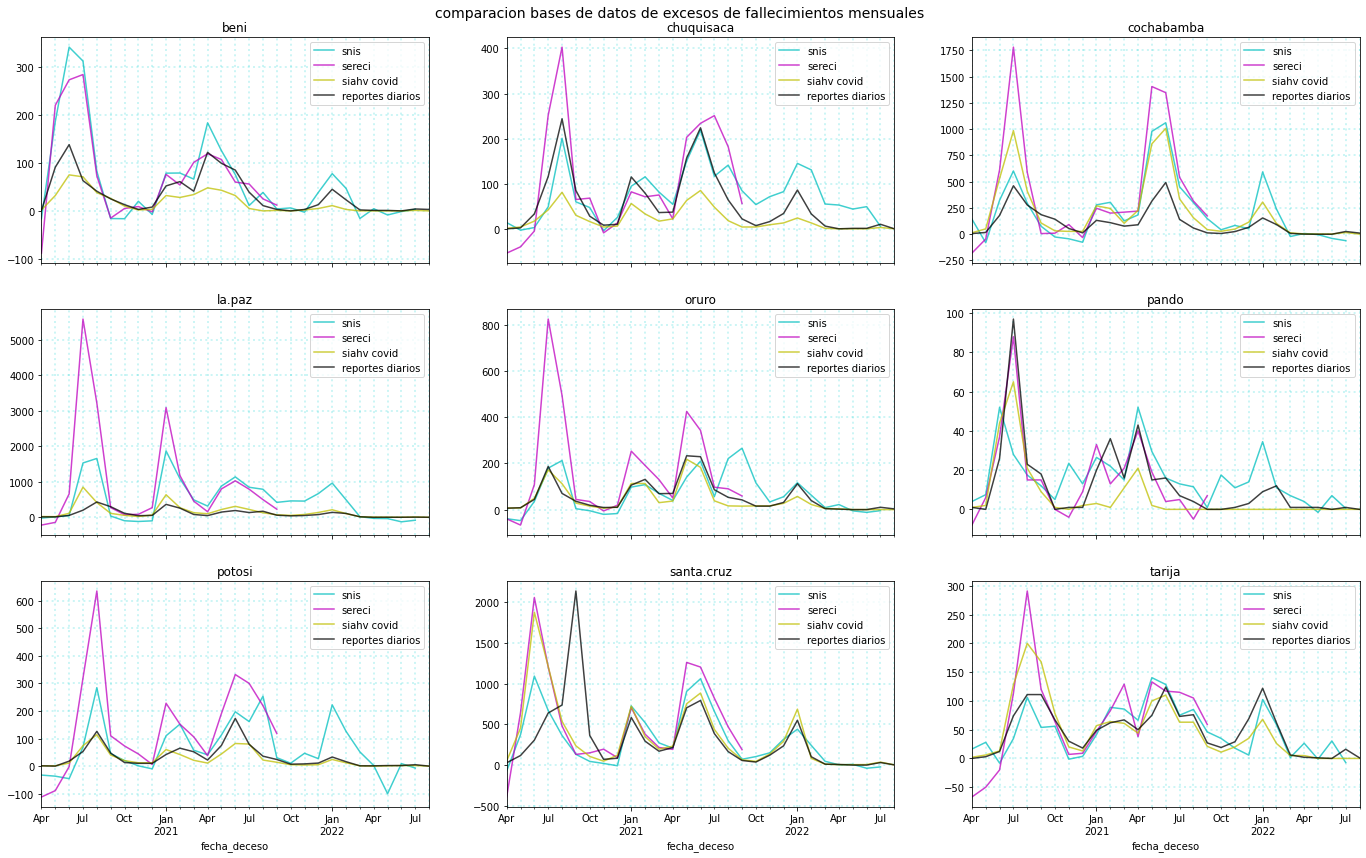

In [42]:
snis_dept_total_plot = snis_mortality_df['2020-04-01':] - snis_bases_df
snis_dept_total_plot = snis_dept_total_plot.dropna(how='all')[
    sorted(reported_deaths_df.columns)
].resample('M').sum()
axs = snis_dept_total_plot.plot(
    subplots=True, 
    layout=(3, 3), 
    color='c', 
    alpha=.75,
    figsize=(60/2.54, 36/2.54)
)
axs = axs.flatten()

sereci_df_plot = resample_sereci_df['2020-04-01':] - sereci_bases_df
sereci_df_plot = sereci_df_plot.dropna(how='all')[
    sorted(reported_deaths_df.columns)
].resample('M').sum()
axs = sereci_df_plot.plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

siahv_dept_plot = siahv_dept_data_.sum(axis=1).unstack(level=0).fillna(0)
siahv_dept_plot = siahv_dept_plot[sorted(reported_deaths_df.columns)].loc['2020-04-01':]
axs = siahv_dept_plot.plot(
    subplots=True, ax=axs, color='y', alpha=.75
)

reported_df_plot = reported_deaths_df[
    sorted(reported_deaths_df.columns)
].diff().resample('M').sum()
reported_df_plot.index = reported_df_plot.index - pd.offsets.MonthBegin(1)
reported_df_plot = reported_df_plot.loc['2020-04':]

axs = reported_df_plot.plot(
    subplots=True, 
    ax=axs, 
    color='k', 
    alpha=.75
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de excesos de fallecimientos mensuales', y=.91, fontsize=14
)
stylize_comparison(axs)

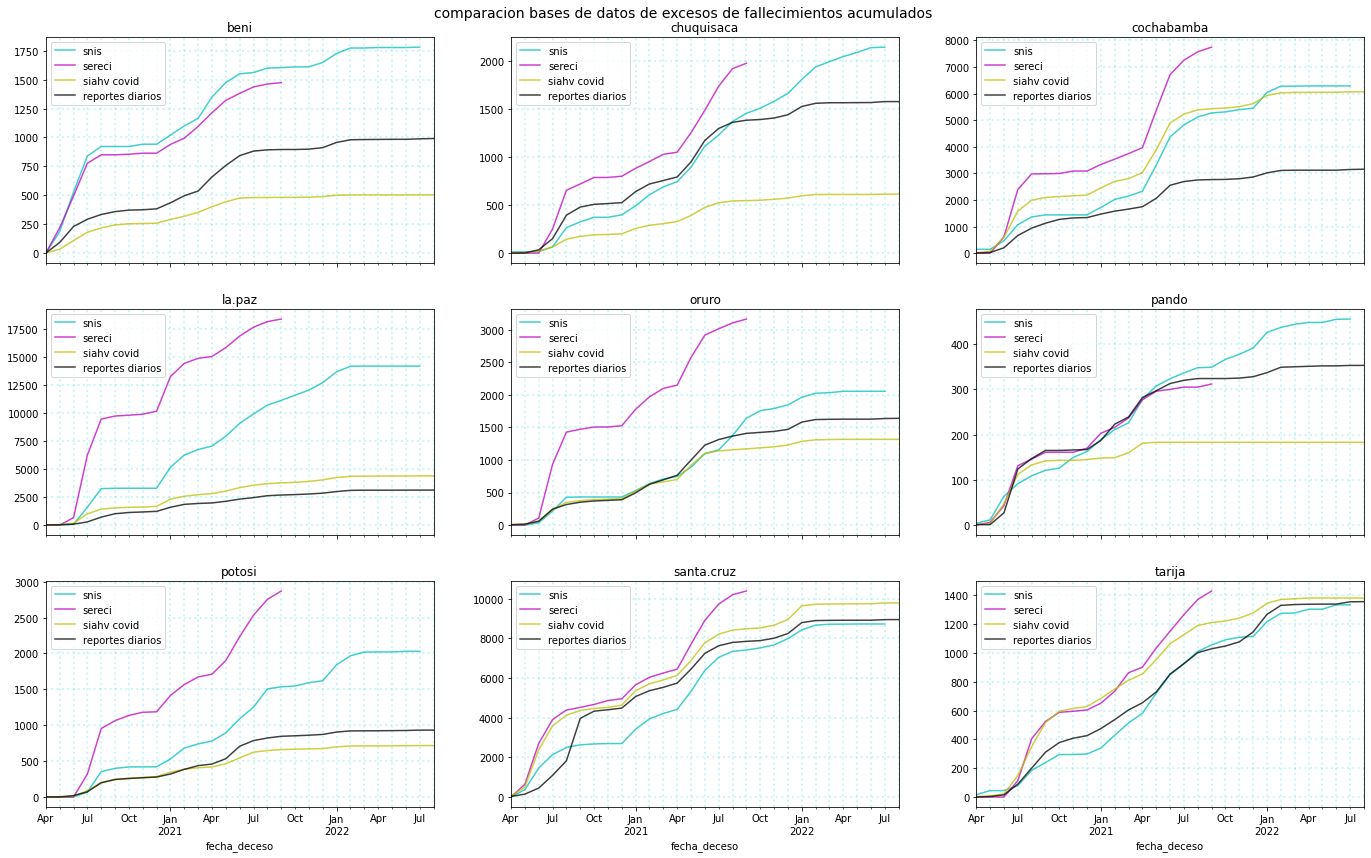

In [43]:
def do_cumsum(df):
    df = df.copy()
    df[df < 0] = 0
    
    return df.cumsum()

axs = do_cumsum(snis_dept_total_plot).plot(
    subplots=True, 
    layout=(3, 3), 
    color='c', 
    alpha=.75,
    figsize=(60/2.54, 36/2.54)
    
)
axs = axs.flatten()

axs = do_cumsum(sereci_df_plot).plot(
    subplots=True, ax=axs, color='m', alpha=.75
)

axs = do_cumsum(siahv_dept_plot).plot(
    subplots=True, ax=axs, color='y', alpha=.75
)

axs = do_cumsum(reported_df_plot).plot(
    subplots=True, 
    ax=axs, 
    color='k', 
    alpha=.75,
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de excesos de fallecimientos acumulados', y=.91, fontsize=14
)
stylize_comparison(axs, loc='upper left')

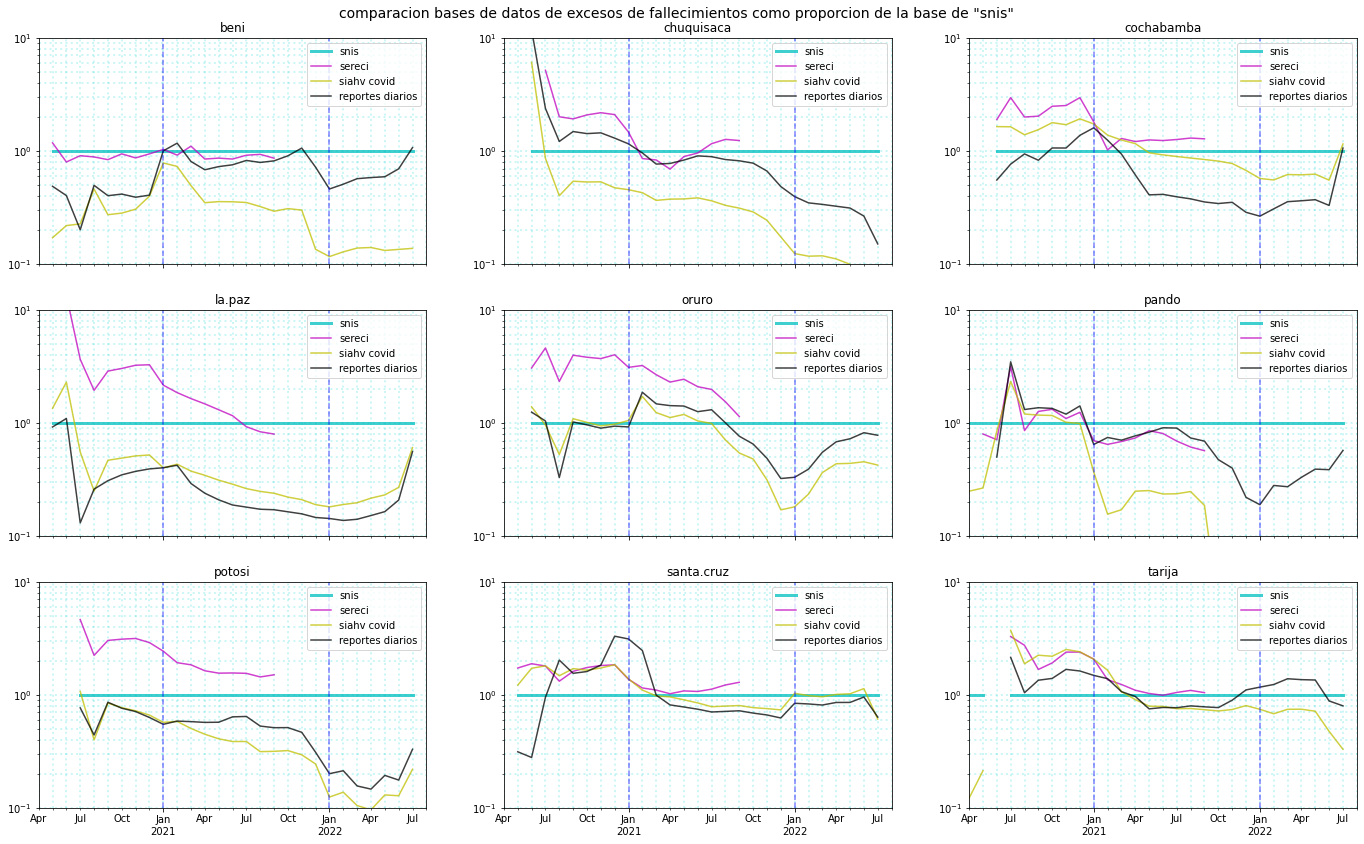

In [44]:
def do_format_(df):
    df = df.copy().resample('M').sum()
    df = df.rolling(window=6).mean().fillna(df)
    df[df < 0.1] = np.nan
    
    return df

axs = (do_format_(snis_dept_total_plot) / do_format_(snis_dept_total_plot)).plot(
    subplots=True, 
    layout=(3, 3), 
    alpha=.75,
    figsize=(60/2.54, 36/2.54),
    logy=True,
    linewidth=3,
    color='c'
)
axs = axs.flatten()

axs = (do_format_(sereci_df_plot) / do_format_(snis_dept_total_plot)).plot(
    subplots=True, 
    ax=axs,
    alpha=.75,
    color='m'
)

axs = (do_format_(siahv_dept_plot.resample('M').sum()) / do_format_(snis_dept_total_plot)).plot(
    subplots=True, 
    ax=axs,
    alpha=.75,
    color='y'
)

axs = (do_format_(reported_df_plot.resample('M').sum()) / do_format_(snis_dept_total_plot)).plot(
    subplots=True, 
    ax=axs,
    alpha=.75,
    color='k'
)

axs[0].get_figure().suptitle(
    'comparacion bases de datos de excesos de fallecimientos como proporcion de la base de "snis"', 
    y=.91, 
    fontsize=14
)
stylize_comparison(axs, loc='upper right')
for ax in axs:
    ax.set_ylim(.1, 10.)
    for year_date in snis_dept_total_plot.resample('Y').first().index[1:]:
        ax.axvline(
            year_date - pd.offsets.DateOffset(years=1, days=-1), 
            color='b', 
            linestyle='--', 
            alpha=.5
        )

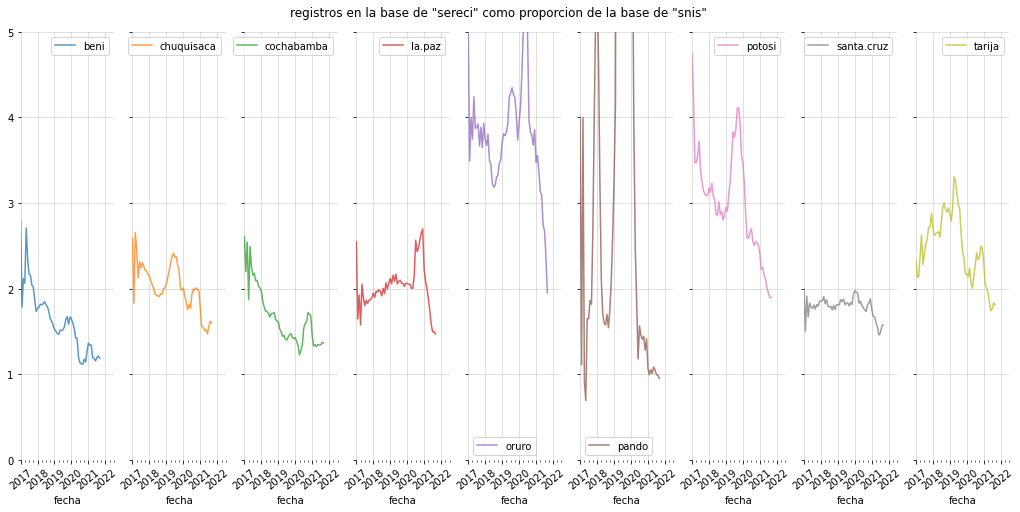

In [45]:
axs = (
    do_format_(resample_sereci_df.loc['2017':]) /
    do_format_(snis_mortality_df.loc[:])
).plot(
    subplots=True, 
    layout=(1, 9), 
    alpha=.75,
    figsize=(45/2.54, 20/2.54),
    sharey=True
)
axs = axs.flatten()

_ = axs[0].get_figure().suptitle(
    'registros en la base de "sereci" como proporcion de la base de "snis"', y=.925
)
_ = axs[0].set_ylim(0, 5)
for ax in axs:
    ax.grid(alpha=.5)
    ax.set(frame_on=False)
    ax.xaxis.set_tick_params(rotation=40)